In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import bisect

sys.path.insert(0, '..')

import keras.layers
from keras.layers import Input, Dense, LocallyConnected1D, Reshape
from keras.models import Model
from keras import regularizers
from sklearn import preprocessing

from IPython.display import SVG
from keras.utils import model_to_dot


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Using TensorFlow backend.


In [2]:
import umap
import umap.plot

In [3]:
raw_df = pd.read_hdf("../data/processed/summaries_protoss.hdf", "summaries")
raw_df = raw_df[raw_df.game_duration > 280]
raw_df.head()

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,TwilightCouncil_start,TwilightCouncil_weight,VoidRay_start,VoidRay_weight,WarpGate_start,WarpGate_weight,WarpPrism_start,WarpPrism_weight,Zealot_start,Zealot_weight
20d6247127ed58eeca069051672d3e8c3598e132d2fc6c445040701499b72acf_0,2020-02-01 15:07:59,675,1.0,ShoWTimE,1.0,0.0,0.0,Trap,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.038405,1.0,1000.0,0.0,1000.000000,0.0
20d6247127ed58eeca069051672d3e8c3598e132d2fc6c445040701499b72acf_1,2020-02-01 15:07:59,675,0.0,Trap,1.0,0.0,0.0,ShoWTimE,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.000000,1.0,1000.0,0.0,1000.000000,0.0
50cb3b2f33692227e2e50e0e4fab529a44c4bfe9bfd9e8137c08a81e94f08370_1,2020-02-02 12:13:08,886,0.0,ShoWTimE,1.0,0.0,0.0,cure,0.0,0.0,...,13.856406,1.000000,1000.0,0.0,13.114877,1.0,1000.0,0.0,13.266499,1.0
038ca41ecf0198facf7425bfd5cfa9237f144e4e41d9c556b204612d55088de1_1,2020-02-02 13:34:45,825,0.0,ShoWTimE,1.0,0.0,0.0,cure,0.0,0.0,...,14.764823,1.927659,1000.0,0.0,13.416408,1.0,1000.0,0.0,1000.000000,0.0
eaa36f7eff9c1682c86aace4ff319bce335f3d61c6e362432c504618e3a95055_0,2020-02-01 14:58:20,531,0.0,ShoWTimE,1.0,0.0,0.0,Trap,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.000000,1.0,1000.0,0.0,1000.000000,0.0


In [4]:
metadata_columns = """
self_won
game_start
game_duration
self_name self_race_is_protoss self_race_is_zerg self_race_is_terran
opponent_name
""".split()
weight_columns = [col for col in raw_df.columns if col.endswith("_weight")]

data_columns = [col for col in raw_df.columns if col not in metadata_columns and col not in weight_columns]

df = raw_df[data_columns]
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns, index=df.index)

encoding_dim = 10

In [5]:
len(data_columns)


48

In [6]:
input_data = Input(shape=(len(df.columns),))

#encoded = Dense(20, activation='relu')(input_data)

encoded = Dense(encoding_dim, activation='relu')(input_data)

#decoded = Dense(20, activation='relu')(encoded)

decoded = Dense(len(df.columns), activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)


In [7]:
encoder = Model(input_data, encoded)


1018


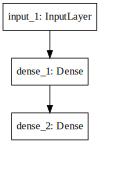

In [8]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
print(autoencoder.count_params())
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))


In [9]:
x_all = df.sample(frac=1.0).values
num_samples = int(0.95 * x_all.shape[0])
x_train, x_test = x_all[:num_samples, :], x_all[num_samples:, :]
print("Training on {} samples. Testing on {}.".format(
    num_samples, x_all.shape[0] - num_samples))


Training on 2855 samples. Testing on 151.


In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=1024,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
cluster_games_df = raw_df[raw_df.game_start > datetime.datetime(2020, 1, 1)]
original_space = min_max_scaler.transform(cluster_games_df[data_columns].values)
encoded_space =autoencoder.predict(original_space)

In [ ]:
encoded_space[0]

In [ ]:
original_space[0]

In [ ]:
diffs = encoded_space - original_space
cluster_games_df['creativity'] = np.einsum("ij,ij->i", diffs, diffs)

In [ ]:
creative_games_df= cluster_games_df.sort_values('creativity')
creative_games_won = creative_games_df[creative_games_df['self_won'] > 0]
creative_games_won.tail(20)

In [ ]:
sns.distplot(cluster_games_df.creativity)

In [ ]:
def summarize_player(*names):
    names = [n.lower() for n in names]
    series = cluster_games_df[cluster_games_df.self_name.str.lower().isin(names)].creativity
    print(series.describe())
    return sns.distplot(series)

def summarize_player_contains(name):
    all_names = set(creative_games_df[creative_games_df['self_name'].str.lower().str.contains(name.lower())].self_name)
    print("Names to use: {}".format(sorted(all_names)))
    return summarize_player(*all_names)

In [ ]:
summarize_player_contains("maxpax")

In [ ]:
summarize_player_contains("dear")

In [ ]:
summarize_player_contains("rotterdam")

In [ ]:
summarize_player_contains("zest")

In [ ]:
summarize_player_contains("skillous")